# Multi Animal DeepLabCut Processing

# Lets try this first on one output file 

In [1]:
import pandas as pd
import numpy as np

# Load the CSV with multi-index headers (4 rows)
csv_path = '/Users/evadevijlder/Downloads/ExcelRAW5individuals/B6_1_A_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv'
df = pd.read_csv(csv_path, header=[0,1,2,3])

# Inspect columns
print(df.columns)

# Filter columns: focus on individual1 and center bodypart
# MultiIndex columns look like: (scorer, individual, bodypart, coord)
cols_of_interest = [col for col in df.columns if col[1] == 'individual1' and col[2] == 'center']
center_df = df.loc[:, cols_of_interest]

# Rename columns for simplicity
center_df.columns = ['x', 'y', 'likelihood']

print(center_df.head())


MultiIndex([(                                                 'scorer', ...),
            ('DLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000', ...),
            ('DLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000', ...),
            ('DLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000', ...),
            ('DLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000', ...),
            ('DLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000', ...),
            ('DLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000', ...),
            ('DLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000', ...),
            ('DLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000', ...),
            ('DLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000', ...),
            ('DLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000', ...),
            ('DLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000', ...),
            ('DLC_resnet50_Gull24_group_neophobiaMar18shuffle1_2

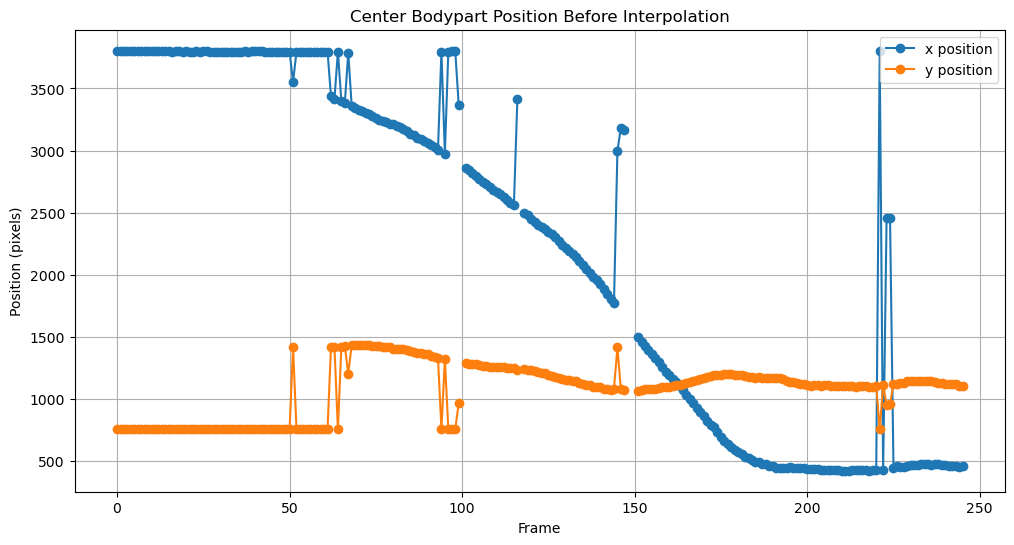

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(center_df.index, center_df['x'], label='x position', marker='o', linestyle='-')
plt.plot(center_df.index, center_df['y'], label='y position', marker='o', linestyle='-')
plt.xlabel('Frame')
plt.ylabel('Position (pixels)')
plt.title('Center Bodypart Position Before Interpolation')
plt.legend()
plt.grid(True)
plt.show()


# Lets try to interpolate
# THIS IS WITHOUT SWAPPING

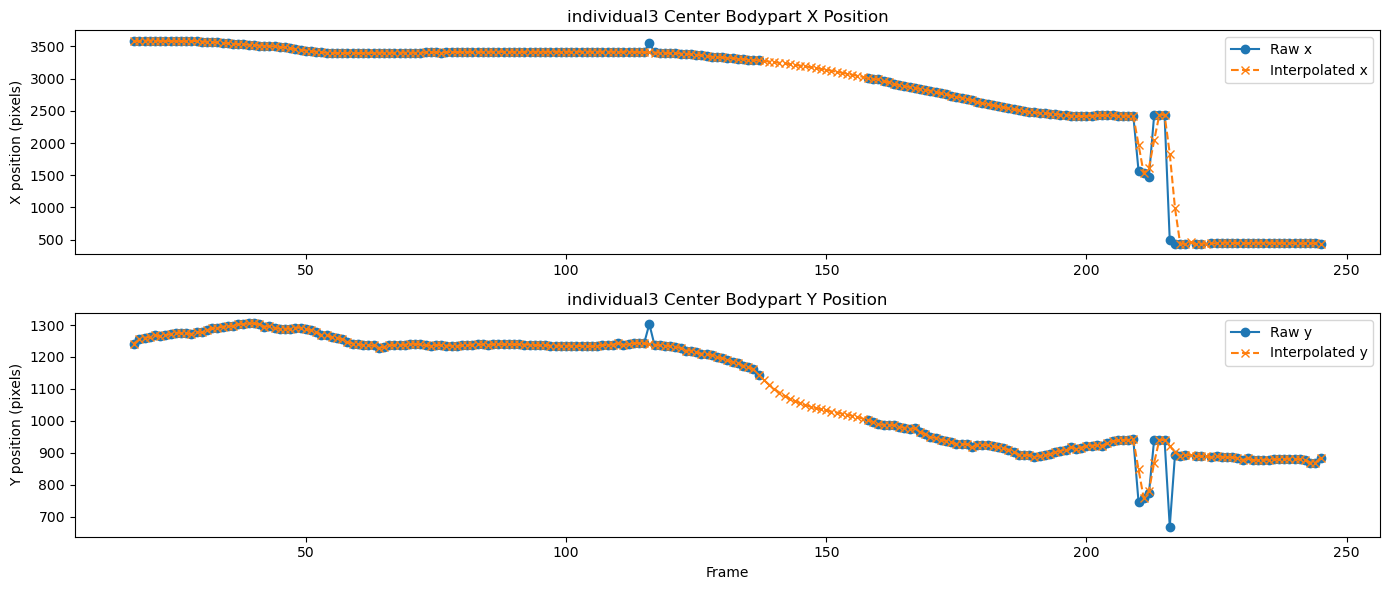

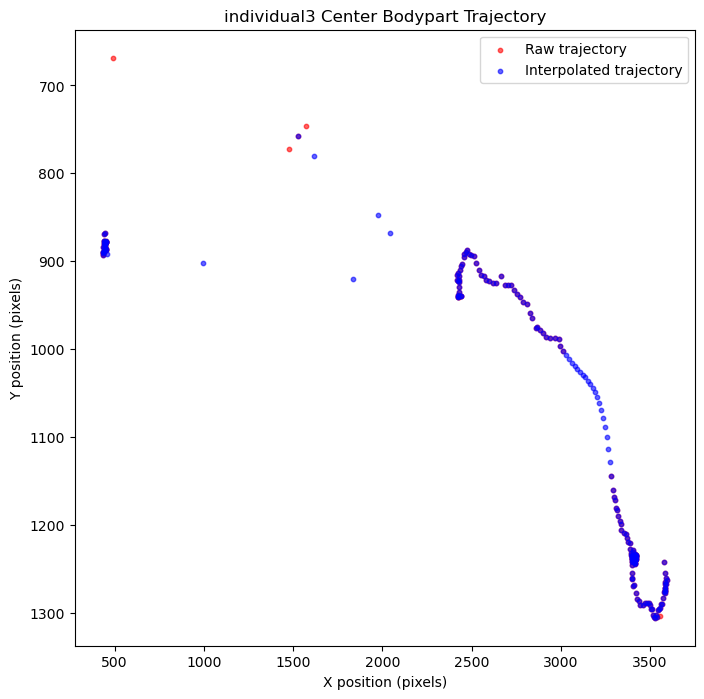

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load CSV with multi-header
csv_path = '/Users/evadevijlder/Downloads/ExcelRAW5individuals/B6_1_A_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv'
df = pd.read_csv(csv_path, header=[0,1,2,3])

# Extract center bodypart columns for one individual
individual = 'individual3'
cols_of_interest = [col for col in df.columns if col[1] == individual and col[2] == 'center']
center_df = df.loc[:, cols_of_interest].copy()
center_df.columns = ['x', 'y', 'likelihood']

# Calculate frame-to-frame speed
center_df['speed'] = np.sqrt((center_df['x'].diff())**2 + (center_df['y'].diff())**2)

# Identify bad frames (speed > 20 or likelihood < 0.8)
bad_frames = (center_df['speed'] > 50) | (center_df['likelihood'] < 0.6)

#NEW AUG 7: (0,0) is invalid data
bad_frames |= ((ind_df['x'] == 0) & (ind_df['y'] == 0))


# Create a copy for interpolation
interp_df = center_df.copy()

# Set bad frames to NaN in x and y for interpolation
interp_df.loc[bad_frames, ['x', 'y']] = np.nan

# Linear interpolation - this is a spline interpolation now 
interp_df[['x', 'y']] = interp_df[['x', 'y']].interpolate(method='spline', order=3)

#NEW 7 august 
ind_df[['x', 'y']] += np.random.normal(0, 1e-6, size=ind_df[['x', 'y']].shape)

# Fill start/end NaNs (if any)
# interp_df[['x', 'y']] = interp_df[['x', 'y']].fillna(method='bfill').fillna(method='ffill') # change here that it doesn interpolate backwards

# Plot raw vs interpolated x and y over frames
plt.figure(figsize=(14,6))

plt.subplot(2,1,1)
plt.plot(center_df.index, center_df['x'], 'o-', label='Raw x')
plt.plot(interp_df.index, interp_df['x'], 'x--', label='Interpolated x')
plt.ylabel('X position (pixels)')
plt.legend()
plt.title(f'{individual} Center Bodypart X Position')

plt.subplot(2,1,2)
plt.plot(center_df.index, center_df['y'], 'o-', label='Raw y')
plt.plot(interp_df.index, interp_df['y'], 'x--', label='Interpolated y')
plt.ylabel('Y position (pixels)')
plt.xlabel('Frame')
plt.legend()
plt.title(f'{individual} Center Bodypart Y Position')

plt.tight_layout()
plt.show()

# Plot raw vs interpolated 2D trajectories
plt.figure(figsize=(8,8))
plt.scatter(center_df['x'], center_df['y'], c='red', s=10, alpha=0.6, label='Raw trajectory')
plt.scatter(interp_df['x'], interp_df['y'], c='blue', s=10, alpha=0.6, label='Interpolated trajectory')
plt.xlabel('X position (pixels)')
plt.ylabel('Y position (pixels)')
plt.title(f'{individual} Center Bodypart Trajectory')
plt.legend()
plt.gca().invert_yaxis()  # invert y axis if needed (typical for video coords)
plt.show()


# lets loop through the entire folder

do this once for the 5individuals folder and once for the 4individuals folder 

In [29]:
#here i adjusted the speed and likelihoods to each file, so they make the best fit instead of using the same thresholds


import os
import pandas as pd
import numpy as np
from glob import glob

# === File Paths ===
input_folder = '/Users/evadevijlder/Downloads/ExcelRAW4individuals/'  # Change as needed
output_file  = '/Users/evadevijlder/Downloads/4individuals_processed.csv'


# === Preprocess Function ===
def preprocess_dlc_file_long(csv_path):
    """
    Process a single DLC CSV for one group of birds.
    Applies dynamic thresholds for speed and likelihood per individual,
    drops pre-entry frames, interpolates bad points, and returns
    a long-format DataFrame.
    """
    print(f"Processing {csv_path}...")
    df = pd.read_csv(csv_path, header=[0,1,2,3])
    basename = os.path.basename(csv_path)
    prefix = basename.split('_cutDLC_resnet50')[0]

    records = []
    # Identify individuals
    individuals = [ind for ind in df.columns.get_level_values(1).unique() if ind.startswith('individual')]

    for ind in individuals:
        # Select center part columns
        cols = [col for col in df.columns if col[1] == ind and col[2] == 'center']
        if len(cols) != 3:
            continue
        ind_df = df.loc[:, cols].copy()
        ind_df.columns = ['x', 'y', 'likelihood']
        ind_df['frame'] = ind_df.index

        # Drop pre-entry rows before first high-confidence detection
        valid = ind_df['likelihood'].notna()
        if not valid.any():
            continue
        first_frame = valid.idxmax()
        ind_df = ind_df[ind_df['frame'] >= first_frame].reset_index(drop=True)

        # Compute instantaneous speed
        ind_df['speed'] = np.sqrt(ind_df['x'].diff()**2 + ind_df['y'].diff()**2)

        # Dynamic thresholds per individual track
        speed_thresh = ind_df['speed'].dropna().quantile(0.99)    # top 1% jumps
        likel_thresh = ind_df['likelihood'].dropna().quantile(0.05)  # bottom 5% confidences

        # Identify bad frames
        bad = (ind_df['speed'] > speed_thresh) | (ind_df['likelihood'] < likel_thresh)
        ind_df.loc[bad, ['x', 'y']] = np.nan

        # Interpolate missing data
        ind_df[['x', 'y']] = ind_df[['x', 'y']].interpolate(method='spline', order=3)
        ind_df[['x', 'y']] = ind_df[['x', 'y']].fillna(method='bfill').fillna(method='ffill')

        # Drop helper column
        ind_df.drop(columns='speed', inplace=True)

        # NEW 7 august; add tiny noise to avoid exact duplicates; 
        ind_df['x'] += np.random.normal(0, 1e-6, size=len(ind_df))
        ind_df['y'] += np.random.normal(0, 1e-6, size=len(ind_df))

        ind_df['Bird_ID'] = f"{prefix}_{ind}"
        records.append(ind_df[['frame', 'Bird_ID', 'x', 'y', 'likelihood']])
        

    if not records:
        return None
    # Combine and return
    return pd.concat(records, ignore_index=True)

# === Main Processing ===
all_data = []
csv_files = glob(os.path.join(input_folder, '*_el.csv'))
for csv_file in csv_files:
    df_proc = preprocess_dlc_file_long(csv_file)
    if df_proc is not None:
        all_data.append(df_proc)

if all_data:
    result_df = pd.concat(all_data, ignore_index=True)

    # Groep op basis van Bird_ID
    result_df['Group'] = result_df['Bird_ID'].str.extract(r'^(.*)_individual\d+$')[0]

    # ❗ Check op TRUE duplicates (meerdere individuen op exact dezelfde locatie in zelfde frame)
    dupes = result_df.groupby(['frame', 'Group', 'x', 'y']).filter(lambda g: g['Bird_ID'].nunique() > 1)

    if not dupes.empty:
        print("⚠️ TRUE duplicates: multiple individuals at same (x, y) in the same frame.")
        print(dupes[['frame', 'Group', 'Bird_ID', 'x', 'y']].head(10))
        print(f"→ Total true duplicates: {len(dupes)}")
    else:
        print("✅ No true duplicates found.")

    # Opslaan pas nadat alles goed is
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    result_df.to_csv(output_file, index=False)
    print(f"✅ Saved processed data to {output_file}")

else:
    print("❌ No valid data processed.")




Processing /Users/evadevijlder/Downloads/ExcelRAW4individuals/B8_7_B_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Processing /Users/evadevijlder/Downloads/ExcelRAW4individuals/B3_8_B_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Processing /Users/evadevijlder/Downloads/ExcelRAW4individuals/B8_1_B_novel_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Processing /Users/evadevijlder/Downloads/ExcelRAW4individuals/B4_7_A_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Processing /Users/evadevijlder/Downloads/ExcelRAW4individuals/B2_7_B_novel_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Processing /Users/evadevijlder/Downloads/ExcelRAW4individuals/B4_3_A_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Processing /Users/evadevijlder/Downloads/ExcelRAW4individuals/B8_3_B_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1

# try it with SWAPPING as well

TRY INDIVIDUAL SWAP 

In [6]:
#just to try this out; only insert the input files that need swaps


input_file = '/Users/evadevijlder/Downloads/ExcelRAW5individuals/B2_7_A_novel_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv' # <-- CHANGE THIS
swap_csv = '/Users/evadevijlder/swap_instructions.csv'


Swap instructions loaded from 
          Group from_individual to_individual  frame_start  frame_end
0  B2_7_A_novel     individual3   individual2         88.0      140.0
1  B2_7_A_novel     individual2   individual3         76.0      140.0
2  B3_6_A_novel     individual2   individual4         39.0       41.0
3  B3_6_A_novel     individual2   individual1         42.0       47.0
4  B3_6_A_novel     individual2   individual1         16.0       38.0
Processing /Users/evadevijlder/Downloads/ExcelRAW5individuals/B6_1_A_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
→ 6.9% of frames marked as bad


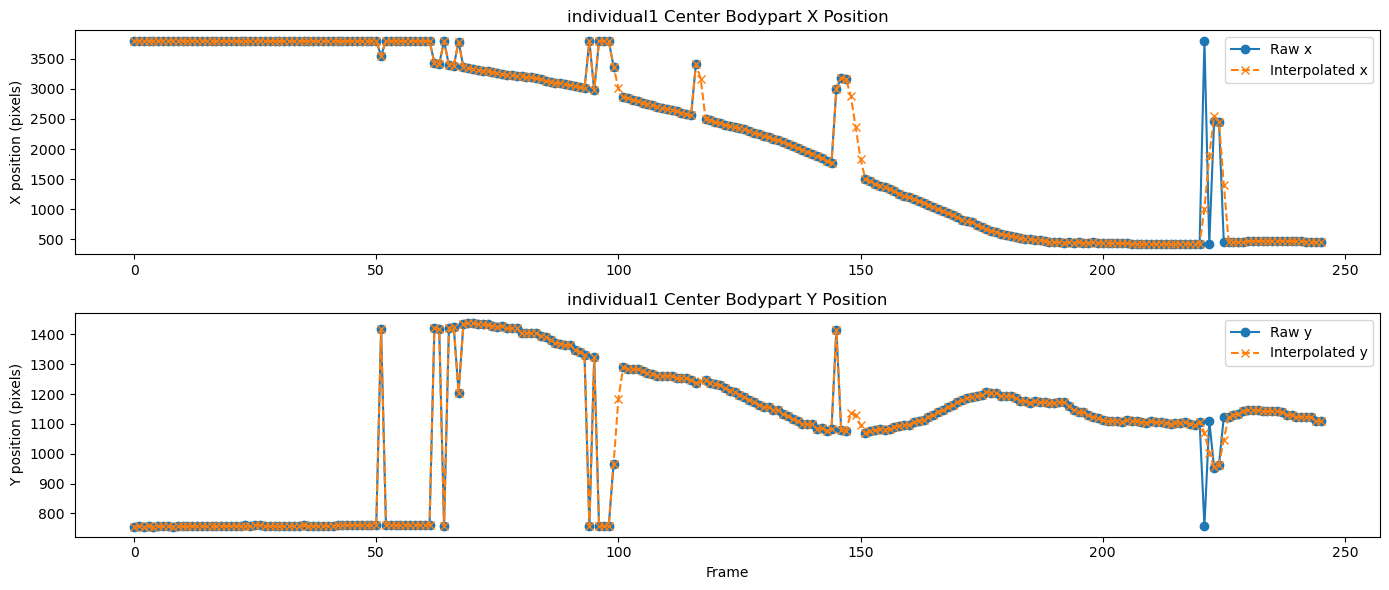

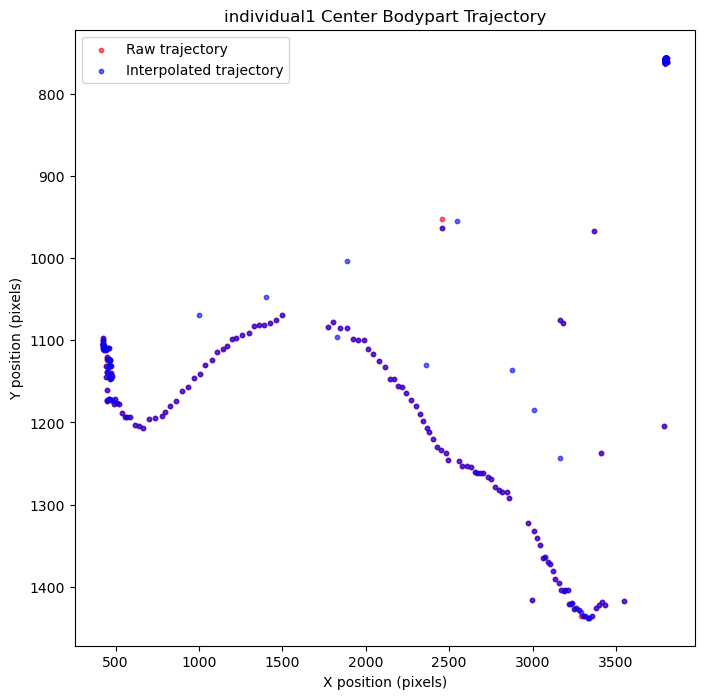

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === File Paths ===
input_file = '/Users/evadevijlder/Downloads/ExcelRAW5individuals/B6_1_A_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv' # <-- CHANGE THIS
swap_csv = '/Users/evadevijlder/swap_instructions.csv'

# === ADJUST THESE ; dus een paar bekijken van de excel files om te zien hoe deze output is en dan de parameters aanpassen === 
# === Parameters === ## 
#speed_threshold = 20
#likelihood_threshold = 0.6

# === Load swap instructions ===
swap_df = pd.read_csv(swap_csv,sep=';')

expected_cols = {'Group', 'from_individual', 'to_individual', 'frame_start', 'frame_end'}
print(f"Swap instructions loaded from ")
print(swap_df.head())
if not expected_cols.issubset(swap_df.columns):
    raise ValueError(f"Swap file must contain columns: {expected_cols}")

def preprocess_and_plot_individual(csv_path, individual_to_plot):
    print(f'Processing {csv_path}...')
    df = pd.read_csv(csv_path, header=[0,1,2,3])
    basename = os.path.basename(csv_path)
    prefix = basename.split('_cutDLC_resnet50')[0]

    individuals = [ind for ind in df.columns.get_level_values(1).unique() if ind.startswith('individual')]
    bodyparts = df.columns.get_level_values(2).unique()

    if 'center' not in bodyparts:
        print(f"Warning: 'center' bodypart not found in {csv_path}, skipping file.")
        return

    if individual_to_plot not in individuals:
        print(f"❌ Individual '{individual_to_plot}' not found in file. Available: {individuals}")
        return

    # Extract relevant columns for the specified individual
    cols = [col for col in df.columns if col[1] == individual_to_plot and col[2] == 'center']
    if len(cols) != 3:
        print(f"Skipping {individual_to_plot}: incomplete 'center' columns.")
        return

    ind_df = df.loc[:, cols].copy()
    ind_df.columns = ['x', 'y', 'likelihood']
    ind_df['frame'] = ind_df.index

    # Save raw data before filtering
    center_df = ind_df[['x', 'y']].copy()

    # Filter & interpolate
    #ind_df['speed'] = np.sqrt(ind_df['x'].diff()**2 + ind_df['y'].diff()**2)
    
    # 1) compute speed
    ind_df['speed'] = np.sqrt((ind_df['x'].diff()**2) + (ind_df['y'].diff()**2))

    # 2) data-driven thresholds
    speed_thresh = ind_df['speed'].dropna().quantile(0.99)
    likelihood_thresh = ind_df['likelihood'].dropna().quantile(0.05)

    # 3) z-score outliers
    speed_z = (ind_df['speed'] - ind_df['speed'].mean()) / ind_df['speed'].std()
    bad_speed = speed_z.abs() > 3

    # 4) final mask
    bad_frames = (
    (ind_df['speed'] > speed_thresh)
    | bad_speed
    | (ind_df['likelihood'] < likelihood_thresh)
    )

# 5) report how many frames we’re dropping
    print(f"→ {bad_frames.mean():.1%} of frames marked as bad")

# 6) remove & interpolate
    ind_df.loc[bad_frames, ['x','y']] = np.nan
    ind_df[['x','y']] = ind_df[['x','y']].interpolate(method='spline', order=3)

    ####

    #ind_df.loc[bad_frames, ['x', 'y']] = np.nan
    #ind_df[['x', 'y']] = ind_df[['x', 'y']].interpolate(method='spline', order=3)
    #ind_df[['x', 'y']] = ind_df[['x', 'y']].fillna(method='bfill').fillna(method='ffill')
    interp_df = ind_df[['x', 'y']].copy()

    # === Plot raw vs interpolated X and Y ===
    plt.figure(figsize=(14,6))

    plt.subplot(2,1,1)
    plt.plot(center_df.index, center_df['x'], 'o-', label='Raw x')
    plt.plot(interp_df.index, interp_df['x'], 'x--', label='Interpolated x')
    plt.ylabel('X position (pixels)')
    plt.legend()
    plt.title(f'{individual_to_plot} Center Bodypart X Position')

    plt.subplot(2,1,2)
    plt.plot(center_df.index, center_df['y'], 'o-', label='Raw y')
    plt.plot(interp_df.index, interp_df['y'], 'x--', label='Interpolated y')
    plt.ylabel('Y position (pixels)')
    plt.xlabel('Frame')
    plt.legend()
    plt.title(f'{individual_to_plot} Center Bodypart Y Position')

    plt.tight_layout()
    plt.show()

    # === Plot 2D trajectory ===
    plt.figure(figsize=(8,8))
    plt.scatter(center_df['x'], center_df['y'], c='red', s=10, alpha=0.6, label='Raw trajectory')
    plt.scatter(interp_df['x'], interp_df['y'], c='blue', s=10, alpha=0.6, label='Interpolated trajectory')
    plt.xlabel('X position (pixels)')
    plt.ylabel('Y position (pixels)')
    plt.title(f'{individual_to_plot} Center Bodypart Trajectory')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()

# === Choose individual and run ===
individual = 'individual1'  # Change to 'individual2', etc.
preprocess_and_plot_individual(input_file, individual)



# LOOP WITH SWAPPING INCLUDED 

In [40]:
import os
import pandas as pd
import numpy as np
from glob import glob

# === File Paths ===
input_folder = '/Users/evadevijlder/Downloads/ExcelRAW5individuals/'  # Change as needed
output_file  = '/Users/evadevijlder/Downloads/5individuals_processed_swap.csv'
swap_csv     = '/Users/evadevijlder/swap_instructions.csv'

# === Load swap instructions ===
swap_df = pd.read_csv(swap_csv, sep=';')
expected_cols = {'Group', 'from_individual', 'to_individual', 'frame_start', 'frame_end'}
if not expected_cols.issubset(swap_df.columns):
    raise ValueError(f"Swap file must contain columns: {expected_cols}")


def preprocess_dlc_file_long(csv_path):
    """
    Read a DLC output CSV, clean each bird's track with dynamic thresholds,
    drop pre-entry frames, and apply manual ID swaps as specified.
    Returns concatenated DataFrame for that file or None if empty.
    """
    print(f"Processing {csv_path}...")
    # Read multi-header DLC CSV
    df = pd.read_csv(csv_path, header=[0,1,2,3])
    basename = os.path.basename(csv_path)
    prefix   = basename.split('_cutDLC_resnet50')[0]

    all_individuals_data = {}

    # STEP 1: Extract & clean each individual
    for ind in df.columns.get_level_values(1).unique():
        if not ind.startswith('individual'):
            continue

        # Select center columns (x,y,likelihood)
        cols = [col for col in df.columns if col[1] == ind and col[2] == 'center']
        if len(cols) != 3:
            print(f"Skipping {ind}: missing center cols.")
            continue

        ind_df = df.loc[:, cols].copy()
        ind_df.columns = ['x', 'y', 'likelihood']
        ind_df['frame'] = ind_df.index

        # Compute instantaneous speed
        ind_df['speed'] = np.sqrt(ind_df['x'].diff()**2 + ind_df['y'].diff()**2)

        # Dynamically compute thresholds based on this individual's data
        speed_thresh = ind_df['speed'].dropna().quantile(0.99)      # top 1% speed jumps
        likel_thresh = ind_df['likelihood'].dropna().quantile(0.05) # bottom 5% confidences

        # Identify bad frames
        bad_frames = (ind_df['speed'] > speed_thresh) | (ind_df['likelihood'] < likel_thresh)
        #NEW AUG 7: (0,0) is invalid data
        bad_frames |= ((ind_df['x'] == 0) & (ind_df['y'] == 0))


        # Mask & interpolate
        ind_df.loc[bad_frames, ['x','y']] = np.nan
        ind_df[['x','y']] = ind_df[['x','y']].interpolate(method='spline', order=3)
        ind_df[['x','y']] = ind_df[['x','y']].fillna(method='bfill').fillna(method='ffill')

        # Drop helper column
        ind_df.drop(columns='speed', inplace=True)

        ind_df['x'] += np.random.normal(0, 0.001)
        ind_df['y'] += np.random.normal(0, 0.001)

        # Drop rows before first valid detection
        valid_xy = ind_df[['x','y']].notnull().all(axis=1)
        if not valid_xy.any():
            continue
        first_frame = valid_xy.idxmax()
        ind_df = ind_df[ind_df['frame'] >= first_frame].reset_index(drop=True)

        # Tag with Bird_ID and collect
        ind_df['Bird_ID'] = f"{prefix}_{ind}"
        all_individuals_data[ind] = ind_df[['frame','x','y','likelihood','Bird_ID']]

    if not all_individuals_data:
        return None

    # STEP 2a: Pivot to frame index
    for ind, df_ind in all_individuals_data.items():
        all_individuals_data[ind] = df_ind.set_index('frame')

    # STEP 2b: Apply swaps
    group_swaps = swap_df[swap_df['Group'] == prefix]
    for _, row in group_swaps.iterrows():
        start, end = int(row.frame_start), int(row.frame_end)
        from_df = all_individuals_data.get(row.from_individual)
        to_df   = all_individuals_data.get(row.to_individual)
        if from_df is None or to_df is None:
            continue
        frames = set(range(start, end+1))
        common = from_df.index.intersection(to_df.index).intersection(frames)

       # Backup the values from to_df before any overwrite
        moved_values = to_df.loc[common, ['x','y','likelihood']].copy()

    # Move coordinates
        from_df.loc[common, ['x','y','likelihood']] = moved_values

    # Clear original location
        to_df.loc[common, ['x','y','likelihood']] = np.nan


    # STEP 2c: Reset index so 'frame' is a column
    for ind, df_ind in all_individuals_data.items():
        all_individuals_data[ind] = df_ind.reset_index()

    # STEP 3: Concatenate & return
    combined = pd.concat(all_individuals_data.values(), ignore_index=True)
    return combined


# Main script to process all files
data_frames = []
for csv_file in glob(os.path.join(input_folder, '*_el.csv')):
    processed = preprocess_dlc_file_long(csv_file)
    if processed is not None:
        data_frames.append(processed)

if data_frames:
    final_df = pd.concat(data_frames, ignore_index=True)
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    final_df.to_csv(output_file, index=False)
    print(f"✅ Done! Saved to {output_file}")
else:
    print("❌ No data processed.")


Processing /Users/evadevijlder/Downloads/ExcelRAW5individuals/B6_7_B_novel_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Skipping individuals: missing center cols.
Processing /Users/evadevijlder/Downloads/ExcelRAW5individuals/B5_4_B_novel_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Skipping individuals: missing center cols.
Processing /Users/evadevijlder/Downloads/ExcelRAW5individuals/B9_6_A_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Skipping individuals: missing center cols.
Processing /Users/evadevijlder/Downloads/ExcelRAW5individuals/B5_6_B_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Skipping individuals: missing center cols.
Processing /Users/evadevijlder/Downloads/ExcelRAW5individuals/B5_2_B_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Skipping individuals: missing center cols.
Processing /Users/evadevijlder/Downloads/ExcelRAW5individua

/Users/evadevijlder/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Processing /Users/evadevijlder/Downloads/ExcelRAW5individuals/B6_1_B_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Skipping individuals: missing center cols.
Processing /Users/evadevijlder/Downloads/ExcelRAW5individuals/B5_8_A_novel_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Skipping individuals: missing center cols.
Processing /Users/evadevijlder/Downloads/ExcelRAW5individuals/B8_7_A_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Skipping individuals: missing center cols.
Processing /Users/evadevijlder/Downloads/ExcelRAW5individuals/B9_4_A_novel_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Skipping individuals: missing center cols.
Processing /Users/evadevijlder/Downloads/ExcelRAW5individuals/B8_3_A_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el.csv...
Skipping individuals: missing center cols.
Processing /Users/evadevijlder/Downloads/ExcelRAW5individua

# merge the 4 and 5 individuals into one data frame

In [41]:
import pandas as pd

# Load CSV files
df1 = pd.read_csv('/Users/evadevijlder/Downloads/4individuals_processed_swap.csv')
df2 = pd.read_csv('/Users/evadevijlder/Downloads/5individuals_processed_swap.csv')

# Find common columns
common_cols = df1.columns.intersection(df2.columns)

# Subset both DataFrames to only those columns
df1_common = df1[common_cols]
df2_common = df2[common_cols]

# Combine the two DataFrames (row-wise)
merged_df = pd.concat([df1_common, df2_common], ignore_index=True)

# Optional: save the merged DataFrame to a new CSV
merged_df.to_csv('/Users/evadevijlder/Downloads/ALL_processed.csv', index=False)


# Extract frames and then add coordinates of the food plate 

In [6]:
import os
import pandas as pd
import glob
import cv2


# Configuration: 4 TOO!!!!!!!!
video_folder = '/Users/evadevijlder/Downloads/5individuals'  # Root folder with videos (and subfolders)
image_folder = '/Users/evadevijlder/Downloads/5individuals/extracted_frames'     # Folder to save extracted frames
csv_filename = '/Users/evadevijlder/Downloads/5individuals/video_frames.csv'     # CSV to save extracted image names
target_frame = 10                  # specify the frame it is supposed to extract 

# === CREATE IMAGE OUTPUT FOLDER ===
script_dir = os.getcwd()  # Current folder in Jupyter
image_folder_path = os.path.join(script_dir, image_folder)
os.makedirs(image_folder_path, exist_ok=True)

print(f"Searching for videos inside: {video_folder}")
print(f"Saving extracted frames to: {image_folder_path}")

# === FIND VIDEO FILES WITH GLOB (recursive, case-insensitive) ===
video_files = []
for ext in ['mp4', 'MP4', 'mov', 'MOV', 'avi', 'AVI', 'mkv', 'MKV']:
    pattern = f"{video_folder}/**/*.{ext}"
    found_files = glob.glob(pattern, recursive=True)
    video_files.extend(found_files)

print(f"Found {len(video_files)} video files:")
for vf in video_files:
    print(vf)

# === PROCESS VIDEOS ===
image_names = []

for video_path in video_files:
    video_file = os.path.basename(video_path)


# 🚫 Skip DLC-labeled videos
    if 'DLC_resnet50' in video_file:
        print(f"⏭️ Skipping DLC-labeled video: {video_file}")
        continue


    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"❌ Failed to open video: {video_file}")
        continue

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"\nProcessing '{video_file}' ({total_frames} frames)")

    if total_frames <= target_frame:
        print(f"⚠️ Video has only {total_frames} frames. Skipping...")
        cap.release()
        continue

    cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)
    ret, frame = cap.read()

    if ret:
        image_name = os.path.splitext(video_file)[0] + '.jpg'
        image_path = os.path.join(image_folder_path, image_name)
        cv2.imwrite(image_path, frame)
        image_names.append(image_name)
        print(f"✅ Extracted frame {target_frame} and saved as {image_name}")
    else:
        print(f"❌ Failed to read frame {target_frame} from {video_file}")

    cap.release()

# === SAVE CSV ===
csv_path = os.path.join(script_dir, csv_filename)
df = pd.DataFrame({'image_name': image_names})
df.to_csv(csv_path, index=False)
print(f"\n✅ Saved CSV with {len(image_names)} entries: {csv_path}")

Searching for videos inside: /Users/evadevijlder/Downloads/5individuals
Saving extracted frames to: /Users/evadevijlder/Downloads/5individuals/extracted_frames
Found 84 video files:
/Users/evadevijlder/Downloads/5individuals/B9_4_A_novel_cut.mp4
/Users/evadevijlder/Downloads/5individuals/B5_6_A_control_cut.mp4
/Users/evadevijlder/Downloads/5individuals/B7_8_B_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el_id_labeled_notrail.mp4
/Users/evadevijlder/Downloads/5individuals/B6_3_A_novel_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el_id_labeled_notrail.mp4
/Users/evadevijlder/Downloads/5individuals/B7_2_B_novel_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el_id_labeled_notrail.mp4
/Users/evadevijlder/Downloads/5individuals/B7_8_B_control_cut.mp4
/Users/evadevijlder/Downloads/5individuals/B5_6_B_control_cutDLC_resnet50_Gull24_group_neophobiaMar18shuffle1_200000_el_id_labeled.mp4
/Users/evadevijlder/Downloads/5individuals/B6_7_B_novel_cut.mp

# Add coordinate of the food plate 

# This has already been done! 

In [13]:
import cv2
import pandas as pd
import os

# === SETTINGS ===
image_folder = '/Users/evadevijlder/Downloads/4individuals/extracted_frames' #or 4ind 
csv_filename = '/Users/evadevijlder/Downloads/4ind_center_food_annotations.csv' #or 4id_center


# === Load image filenames ===
image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith('.jpg')])
results = []

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path)

    if image is None:
        print(f"⚠️ Failed to load {image_file}")
        continue

    original = image.copy()
    clicked_point = []

    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            clicked_point.clear()
            clicked_point.append((x, y))
            redraw_image()

    def redraw_image():
        image[:] = original.copy()
        if clicked_point:
            cv2.circle(image, clicked_point[0], 6, (0, 0, 255), -1)
        cv2.imshow("Image", image)

    cv2.namedWindow("Image")
    cv2.setMouseCallback("Image", click_event)
    redraw_image()

    print(f"\n📸 Image: {image_file}")
    print("👆 Click 1 point. Press 'c' to clear. Close the window to continue.")

    while True:
        if len(clicked_point) == 1:
            break
        if cv2.getWindowProperty("Image", cv2.WND_PROP_VISIBLE) < 1:
            break
        key = cv2.waitKey(100) & 0xFF
        if key == ord('c'):
            clicked_point.clear()
            redraw_image()

    cv2.destroyAllWindows()

    if len(clicked_point) != 1:
        print(f"❌ No point selected for {image_file}. Skipping...")
        continue

    result = {
        'image_name': image_file,
        'x': clicked_point[0][0],
        'y': clicked_point[0][1]
    }
    results.append(result)

# === Save all points to CSV ===
df = pd.DataFrame(results)
df.to_csv(csv_filename, index=False)
print(f"\n✅ Saved {len(results)} single points to {csv_filename}")



📸 Image: B2_1_A_control_cut.jpg
👆 Click 1 point. Press 'c' to clear. Close the window to continue.

📸 Image: B2_1_B_control_cut.jpg
👆 Click 1 point. Press 'c' to clear. Close the window to continue.

📸 Image: B2_3_A_novel_cut.jpg
👆 Click 1 point. Press 'c' to clear. Close the window to continue.

📸 Image: B2_3_B_novel_cut.jpg
👆 Click 1 point. Press 'c' to clear. Close the window to continue.

📸 Image: B2_5_A_control_cut.jpg
👆 Click 1 point. Press 'c' to clear. Close the window to continue.

📸 Image: B2_5_B_control_cut.jpg
👆 Click 1 point. Press 'c' to clear. Close the window to continue.

📸 Image: B2_7_A_novel_cut.jpg
👆 Click 1 point. Press 'c' to clear. Close the window to continue.

📸 Image: B2_7_B_novel_cut.jpg
👆 Click 1 point. Press 'c' to clear. Close the window to continue.

📸 Image: B3_2_A_novel_cut.jpg
👆 Click 1 point. Press 'c' to clear. Close the window to continue.

📸 Image: B3_2_B_novel_cut.jpg
👆 Click 1 point. Press 'c' to clear. Close the window to continue.

📸 Image: B3

In [5]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 MB 34.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 37.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 2.0.2 which is incompatible.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


# merge the files

In [14]:
import pandas as pd

# Load CSV files
df1 = pd.read_csv('/Users/evadevijlder/Downloads/4ind_center_food_annotations.csv')
df2 = pd.read_csv('/Users/evadevijlder/Downloads/5ind_center_food_annotations.csv')

# Find common columns
common_cols = df1.columns.intersection(df2.columns)

# Subset both DataFrames to only those columns
df1_common = df1[common_cols]
df2_common = df2[common_cols]

# Combine the two DataFrames (row-wise)
merged_df = pd.concat([df1_common, df2_common], ignore_index=True)

# Optional: save the merged DataFrame to a new CSV
merged_df.to_csv('/Users/evadevijlder/center_food_annotations.csv', index=False)


# lets try to add neighbours, distances and rank 


this is with food plate coordinates instead of origin

In [45]:

import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import rankdata

# File paths
input_csv = '/Users/evadevijlder/Downloads/ALL_processed.csv'
center_csv = '/Users/evadevijlder/center_food_annotations.csv'
output_csv = '/Users/evadevijlder/Downloads/rank_and_nn_outputLAST.csv'

# Load main bird tracking data
df = pd.read_csv(input_csv)

# Load manually annotated center points
center_df = pd.read_csv(center_csv)
center_df['Group'] = center_df['image_name'].str.replace('_cut.jpg', '', regex=False)

# Ensure required columns exist
required = {'frame', 'Bird_ID', 'x', 'y'}
if not required.issubset(df.columns):
    raise ValueError(f"Missing required columns: {required}")

# Extract group name from Bird_ID
df['Group'] = df['Bird_ID'].str.extract(r'^(.*)_individual\d+$')[0]

# DEBUG: hoeveel unieke Bird_IDs per locatie?
df_grouped = df.groupby(['frame', 'Group', 'x', 'y'])['Bird_ID'].nunique().reset_index()
df_grouped = df_grouped[df_grouped['Bird_ID'] > 1]
print("🔍 Unieke Bird_IDs per locatie waar er meerdere zijn:")
print(df_grouped.head(10))

# Echte duplicaten
dupes_correct = df[
    df.duplicated(subset=['frame', 'Group', 'x', 'y'], keep=False) &
    (df.groupby(['frame', 'Group', 'x', 'y'])['Bird_ID'].transform('nunique') > 1)
]

if not dupes_correct.empty:
    print("⚠️ TRUE duplicates: multiple individuals at same (x, y) in the same frame.")
    print(dupes_correct[['frame', 'Group', 'Bird_ID', 'x', 'y']].drop_duplicates().head(10))
    print(f"→ Total true duplicates: {len(dupes_correct)}")
else:
    print("✅ No true duplicates found.")


# === RANKING + NEAREST NEIGHBOR ===
results = []

# Group by frame and group
for (frame, group), group_df in df.groupby(['frame', 'Group']):

    # Filter out invalid coordinates: NaN or (0,0)
    valid = group_df[['x', 'y']].notnull().all(axis=1) & ~((group_df['x'] == 0) & (group_df['y'] == 0))
    filtered_df = group_df[valid]

    if len(filtered_df) < 2:
        continue

    coords = filtered_df[['x', 'y']].to_numpy()
    ids = filtered_df['Bird_ID'].values

    # Get center point for this group
    center_row = center_df[center_df['Group'] == group]
    if center_row.empty:
        print(f"⚠️ No center point for group {group}. Skipping.")
        continue

    center_point = center_row[['x', 'y']].values[0]

    # Calculate distance from each bird to the center point
    dist_from_center = np.linalg.norm(coords - center_point, axis=1)
    rank = rankdata(dist_from_center, method='min')

    # Pairwise distances for nearest neighbor
    pairwise = squareform(pdist(coords))
    np.fill_diagonal(pairwise, np.nan)

    pairwise[pairwise < 1e-3] = np.nan  # Ignore almost-identical points
    nearest = np.nanmin(pairwise, axis=1)

    for i in range(len(ids)):
        results.append({
            'frame': frame,
            'Group': group,
            'Bird_ID': ids[i],
            'x': coords[i, 0],
            'y': coords[i, 1],
            'rank_from_center': rank[i],
            'nearest_neighbor_distance': nearest[i]
        })

# Save output
out_df = pd.DataFrame(results)
out_df.to_csv(output_csv, index=False)
print(f"✅ Done. Output saved to: {output_csv}")



🔍 Unieke Bird_IDs per locatie waar er meerdere zijn:
Empty DataFrame
Columns: [frame, Group, x, y, Bird_ID]
Index: []
✅ No true duplicates found.
✅ Done. Output saved to: /Users/evadevijlder/Downloads/rank_and_nn_outputLAST.csv


In [46]:
# 🔍 Check op lege waarden in 'nearest_neighbor_distance'
missing_count = out_df['nearest_neighbor_distance'].isna().sum()
print(f"🔍 Aantal rijen zonder geldige 'nearest_neighbor_distance': {missing_count}")

# Eventueel toon enkele voorbeelden
print(out_df[out_df['nearest_neighbor_distance'].isna()][['frame', 'Group', 'Bird_ID']].head(10))

🔍 Aantal rijen zonder geldige 'nearest_neighbor_distance': 0
Empty DataFrame
Columns: [frame, Group, Bird_ID]
Index: []


In [38]:
    # === Optional: check for TRUE duplicates ===
    final_df['Group'] = final_df['Bird_ID'].str.extract(r'^(.*)_individual\d+$')[0]
    dupes = final_df.groupby(['frame', 'Group', 'x', 'y']).filter(lambda g: g['Bird_ID'].nunique() > 1)

    if not dupes.empty:
        print("⚠️ TRUE duplicates: multiple individuals at same (x, y) in the same frame.")
        print(dupes[['frame', 'Group', 'Bird_ID', 'x', 'y']].drop_duplicates().head(10))
        print(f"→ Total true duplicates: {len(dupes)}")
    else:
        print("✅ No true duplicates found.")


✅ No true duplicates found.


# lets try a convex hull as well
Same output as above but additional file to get are covered per frame 

# IGNORE THIS ONE 

In [3]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import rankdata
from scipy.spatial import ConvexHull

# File paths
input_csv = '/Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/ALL_processed.csv'
center_csv = '/Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/center_food_annotations.csv'
output_individual_csv = '/Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/rank_and_nn_output2.csv'
output_group_csv = '/Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/group_cohesion_output.csv'

# Load main bird tracking data
df = pd.read_csv(input_csv)

# Load your manually annotated center points
center_df = pd.read_csv(center_csv)
center_df['Group'] = center_df['image_name'].str.replace('_cut.jpg', '', regex=False)

# Ensure required columns exist
required = {'frame', 'Bird_ID', 'x', 'y'}
if not required.issubset(df.columns):
    raise ValueError(f"Missing required columns: {required}")

# Extract group name from Bird_ID
df['Group'] = df['Bird_ID'].str.extract(r'^(.*)_individual\d+$')[0]

# Output storage
individual_results = []
group_results = []

# Group by frame and group
for (frame, group), group_df in df.groupby(['frame', 'Group']):
    coords = group_df[['x', 'y']].to_numpy()
    ids = group_df['Bird_ID'].values

    if len(coords) < 2:
        continue

    # Get center point
    center_row = center_df[center_df['Group'] == group]
    if center_row.empty:
        print(f"⚠️ No center point for group {group}. Skipping.")
        continue
    center_point = center_row[['x', 'y']].values[0]

    # === Individual-Level Metrics ===
    dist_from_center = np.linalg.norm(coords - center_point, axis=1)
    rank = rankdata(dist_from_center, method='min')
    pairwise = squareform(pdist(coords))
    np.fill_diagonal(pairwise, np.nan)
    nearest = np.nanmin(pairwise, axis=1)

    for i in range(len(ids)):
        individual_results.append({
            'frame': frame,
            'Group': group,
            'Bird_ID': ids[i],
            'x': coords[i, 0],
            'y': coords[i, 1],
            'rank_from_center': rank[i],
            'nearest_neighbor_distance': nearest[i]
        })

    # === Group-Level Metric: Convex Hull Area ===
    if len(coords) >= 3:
        try:
            hull = ConvexHull(coords)
            hull_area = hull.area
        except Exception as e:
            print(f"⚠️ Could not compute convex hull for group {group}, frame {frame}: {e}")
            hull_area = np.nan
    else:
        hull_area = np.nan  # Not enough points for convex hull

    group_results.append({
        'frame': frame,
        'Group': group,
        'num_individuals': len(coords),
        'convex_hull_area': hull_area
    })

# Save outputs
pd.DataFrame(individual_results).to_csv(output_individual_csv, index=False)
pd.DataFrame(group_results).to_csv(output_group_csv, index=False)

print(f"✅ Done. Saved:")
print(f"   Individual metrics ➜ {output_individual_csv}")
print(f"   Group cohesion (convex hull) ➜ {output_group_csv}")


✅ Done. Saved:
   Individual metrics ➜ /Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/rank_and_nn_output2.csv
   Group cohesion (convex hull) ➜ /Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/group_cohesion_output.csv


In [ ]:
# Na het inladen van je dataframe
zero_coords = df[(df['x'] == 0) | (df['y'] == 0)]
print(f"Aantal rijen met exacte 0-coördinaten: {len(zero_coords)}")

#drop rows with no coordinates?
#df = df.dropna(subset=['x', 'y'])


Aantal rijen met exacte 0-coördinaten: 0


# have a first look at this
compare control vs novel average areas covered across all frames

Larger areas = more spread out; less cohesive
Smaller areas = less spread out; more cohesive 


📊 Descriptive statistics by condition:

              mean       std     min         max  count
condition                                              
control    2048.15   1536.84  302.02    15410.36   4730
novel      4141.31  40217.22  342.26  1436030.24   5523


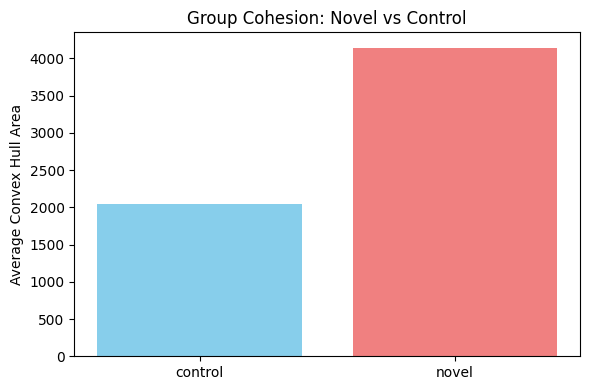

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the convex hull output CSV
group_df = pd.read_csv('/Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/group_cohesion_output.csv')

# Step 1: Extract condition (either "control" or "novel") from Group
group_df['condition'] = group_df['Group'].str.extract(r'(control|novel)$')

# Step 2: Basic Descriptives
descriptives = group_df.groupby('condition')['convex_hull_area'].agg(['mean', 'std', 'min', 'max', 'count']).round(2)
print("\n📊 Descriptive statistics by condition:\n")
print(descriptives)



# Step 3: Plot
plt.figure(figsize=(6, 4))
plt.bar(avg_area['condition'], avg_area['convex_hull_area'], color=['skyblue', 'lightcoral'])
plt.ylabel('Average Convex Hull Area')
plt.title('Group Cohesion: Novel vs Control')
plt.tight_layout()
plt.show()

# draw the convex hull to visualise it
it is the average now per group 

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import os

# Load full tracking data
df = pd.read_csv('/Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/ALL_processed.csv')

# Extract group and condition
df['Group'] = df['Bird_ID'].str.extract(r'^(.*)_individual\d+$')[0]
df['condition'] = df['Group'].str.extract(r'(control|novel)$')

# Average coordinates per individual across frames
avg_coords = df.groupby(['Group', 'condition', 'Bird_ID'])[['x', 'y']].mean().reset_index()

# Output folder to save plots (optional)
output_folder = '/Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/convex_hull_plots'
os.makedirs(output_folder, exist_ok=True)

colors = {'control': 'blue', 'novel': 'red'}

for group in avg_coords['Group'].unique():
    group_df = avg_coords[avg_coords['Group'] == group]
    condition = group_df['condition'].iloc[0]

    coords = group_df[['x', 'y']].to_numpy()

    if len(coords) < 3:
        print(f"Skipping group {group} (not enough points for convex hull)")
        continue

    hull = ConvexHull(coords)

    plt.figure(figsize=(6, 6))
    plt.title(f'Convex Hull for Group: {group} ({condition})')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')

    # Plot average individual points
    plt.plot(coords[:, 0], coords[:, 1], 'o', color=colors[condition], label='Individuals')

    # Plot hull edges
    for simplex in hull.simplices:
        plt.plot(coords[simplex, 0], coords[simplex, 1], '-', color=colors[condition], alpha=0.7)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.tight_layout()

    # Save plot or show
    save_path = os.path.join(output_folder, f'{group}_convex_hull.png')
    plt.savefig(save_path)
    plt.close()
    print(f"Saved convex hull plot for {group} at {save_path}")


Saved convex hull plot for B2_1_A_control at /Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/convex_hull_plots/B2_1_A_control_convex_hull.png
Saved convex hull plot for B2_1_B_control at /Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/convex_hull_plots/B2_1_B_control_convex_hull.png
Saved convex hull plot for B2_3_A_novel at /Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/convex_hull_plots/B2_3_A_novel_convex_hull.png
Saved convex hull plot for B2_3_B_novel at /Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/convex_hull_plots/B2_3_B_novel_convex_hull.png
Saved convex hull plot for B2_5_A_control at /Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/convex_hull_plots/B2_5_A_control_convex_hull.png
Saved convex hull plot for B2_5_B_control at /Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/convex_hull_plots/B2_5_B_control_convex_hull.png
Saved convex hull plot for B2_7_A_novel at /Volumes/Untitled/Gull24_Neo_group_Upsc_CUT/convex_hull_plots/B2_7_A_novel_convex_hull.png
Saved convex hull plot for B2_7_B_novel at /Vo